In [83]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("Merged_Microplastic_Data.csv")

# Display the first few rows to get an overview of the data structure
df.head()

# Check for null values across all columns to assess data quality
df.isnull().sum()

Unnamed: 0                                0
DOI                                       0
Sample_ID                                 0
Location                                149
Countries                               149
Source                                    0
Concentration                             6
Concentration_Units                       6
Approximate_Latitude                    155
Approximate_Longitude                   155
Sample_device_and_deployment_methods     21
Digestion                                21
Filtration                               21
Filter_Size                              21
Microplastic_Identification_Method       21
Spectral_Analysis                        21
Controls                                 21
dtype: int64

# Dataset Overview
#### The dataset is loaded and inspected for missing values. This step ensures that any subsequent cleaning or preprocessing accurately addresses data quality issues.

In [84]:
# Drop rows with missing values in key columns
df = df.dropna(subset=['Concentration', 'Concentration_Units'])

# Convert 'Concentration' to numeric, coercing non-numeric values to NaN
df['Concentration'] = pd.to_numeric(df['Concentration'], errors='coerce')

# Create a clean copy for further processing
df = df.dropna(subset=['Concentration', 'Concentration_Units'])

### Create an IQR cell that gets rid of outliers in the ‘Concentration’ column for all countries

In [85]:
# Drop rows with missing values in key columns
df = df.dropna(subset=['Concentration', 'Concentration_Units'])

# Convert 'Concentration' to numeric, coercing non-numeric values to NaN
df['Concentration'] = pd.to_numeric(df['Concentration'], errors='coerce')

# Create a clean copy for further processing
df = df.dropna(subset=['Concentration', 'Concentration_Units'])

# 1. Compute Q1, Q3 and IQR
Q1 = df['Concentration'].quantile(0.25)
Q3 = df['Concentration'].quantile(0.75)
IQR = Q3 - Q1

# 2. Compute the bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 3. Filter df in place so only values within [lower_bound, upper_bound] remain
df = df[
    (df['Concentration'] >= lower_bound) &
    (df['Concentration'] <= upper_bound)
].copy()
df

,Unnamed: 0,DOI,Sample_ID,Location,Countries,Source,Concentration,Concentration_Units,Approximate_Latitude,Approximate_Longitude,Sample_device_and_deployment_methods,Digestion,Filtration,Filter_Size,Microplastic_Identification_Method,Spectral_Analysis,Controls
0,0,10.1016/j.watres.2017.11.011,1|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,14.0,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
1,1,10.1016/j.watres.2017.11.011,2|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,118.0,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
2,2,10.1016/j.watres.2017.11.011,3|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,50.0,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
3,3,10.1016/j.watres.2017.11.011,4|10.1016/j.watres.2017.11.011,Germany,Germany,bottled water,11.0,particles/L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,polycarbonate filter,3 um,"Single Particle Explorer (SPE, rapID, Berlin)",Raman,Blank filters run through Raman
5,5,10.1039/c6ay01184e,2|10.1039/c6ay01184e,Germany,Germany,bottled water,1.0,particles/0.33 L,51.163818,10.447831,Pre packaged bevarage cartons,Not Provided,Cellulose nitrate,0.45 um,Raman scattering spectroscopy,Raman,Already analyzes sample filtered a second time...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,591,10.1007/s11356-021-13769-x,July_Tap|10.1007/s11356-021-13769-x,XiangJiang River,China,tap water,405.0,particles/L,35.000074,104.999927,DWTP,H2O2,Alumina filter,0.2 um,Stereomicroscopy,FTIR,Plastic equiptment minimized
592,592,10.1016/j.scitotenv.2021.148001,TCQS|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,400.0,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized
602,602,10.1016/j.scitotenv.2021.148001,Spr|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,390.0,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized
603,603,10.1016/j.scitotenv.2021.148001,Sum|10.1016/j.scitotenv.2021.148001,"South-to-North Water Diversion Project, China",China,tap water,360.0,particles/m3,35.000074,104.999927,Drinking water canal,H2O2,Glass fiber,Not Provided,Not Provided,Not Provided,Plastic equiptment minimized


### Unit Conversion
Using a helper function, the `Concentration` values are converted to a consistent unit (particles/L) and stored in a new column, `Concentration_std`. This ensures that we can compare values across different measurement units.

In [86]:
# Define a function to convert various concentration units to particles/L
def convert_concentration(value, unit):
    conversion_factors = {
        'particles/L': 1,
        'particles/0.33 L': 1 / 0.33,
        'particles/50 L': 1 / 50,
        'particles/mL': 1000,
        'particles/m3': 1 / 1000
    }
    if np.isnan(value) or unit not in conversion_factors:
        return np.nan
    else:
        return value * conversion_factors[unit]

# Apply the conversion to standardize the concentration values
df['Concentration_std'] = df.apply(
    lambda row: convert_concentration(row['Concentration'], row['Concentration_Units']),
    axis=1
)

### Data Aggregation by Country
The dataset is grouped by `Countries` to calculate both total and average microplastic concentration values. To ensure statistical validity, only countries with at least 10 samples are included.

In [87]:
# Aggregate total and average standardized concentration by country, along with sample counts
country_stats = df.groupby('Countries').agg(
    total_std_concentration=('Concentration_std', 'sum'),
    avg_std_concentration=('Concentration_std', 'mean'),
    sample_count=('Concentration_std', 'count')
).reset_index()

# Filter out countries with fewer than 10 samples for robust analysis
country_stats = country_stats[country_stats['sample_count'] >= 10]

# For plotting, identify the top 10 countries by total and average concentrations
top10_total = country_stats.sort_values(by='total_std_concentration', ascending=False).head(10)
top10_total = top10_total.sort_values(by='total_std_concentration', ascending=True)

top10_avg = country_stats.sort_values(by='avg_std_concentration', ascending=False).head(10)
top10_avg = top10_avg.sort_values(by='avg_std_concentration', ascending=True)

#### Bar Plot: Total Concentrations
This bar plot displays the total microplastic concentration (standardized to particles/L) for the top 10 countries with sufficient samples. Each bar is labeled with the respective concentration value.

C:\Users\arman\AppData\Local\Temp\ipykernel_1996\2132189602.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=top10_total, x='total_std_concentration', y='Countries', palette='viridis')


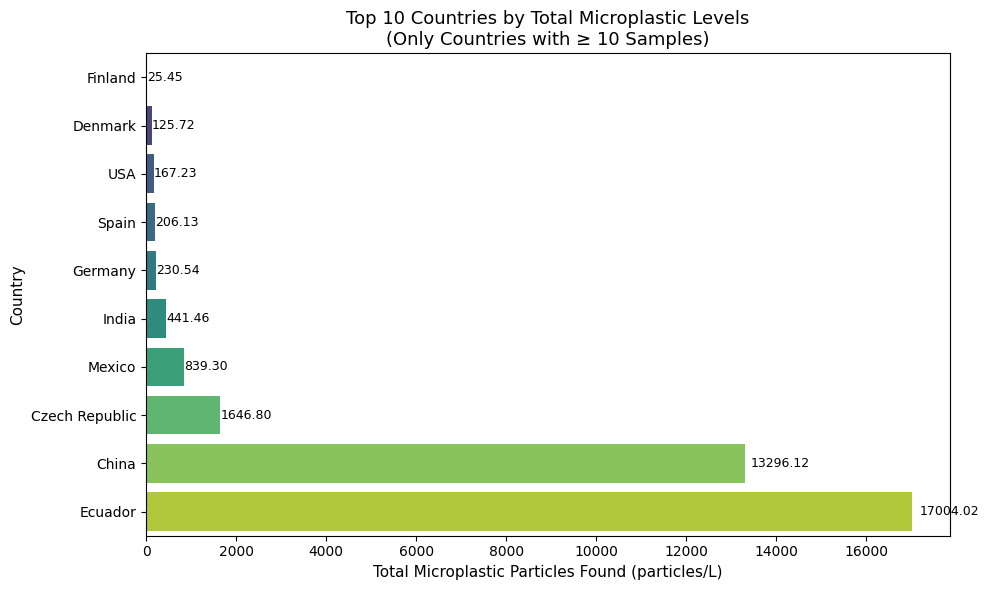

In [88]:
# Plot: Top 10 Countries by Total Standardized Concentration
plt.figure(figsize=(10, 6))
ax1 = sns.barplot(data=top10_total, x='total_std_concentration', y='Countries', palette='viridis')
plt.xlabel('Total Microplastic Particles Found (particles/L)', fontsize=11)
plt.ylabel('Country', fontsize=11)
plt.title('Top 10 Countries by Total Microplastic Levels\n(Only Countries with ≥ 10 Samples)', fontsize=13)

# Annotate bars with the total concentration values
for patch in ax1.patches:
    width = patch.get_width()
    ax1.text(width + (width * 0.01),
             patch.get_y() + patch.get_height() / 2,
             f'{width:.2f}',
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

#### Bar Plot: Average Concentrations
This plot shows the average microplastic concentration for the top 10 countries, again only considering those with at least 10 samples.

C:\Users\arman\AppData\Local\Temp\ipykernel_1996\3905616355.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=top10_avg, x='avg_std_concentration', y='Countries', palette='viridis')


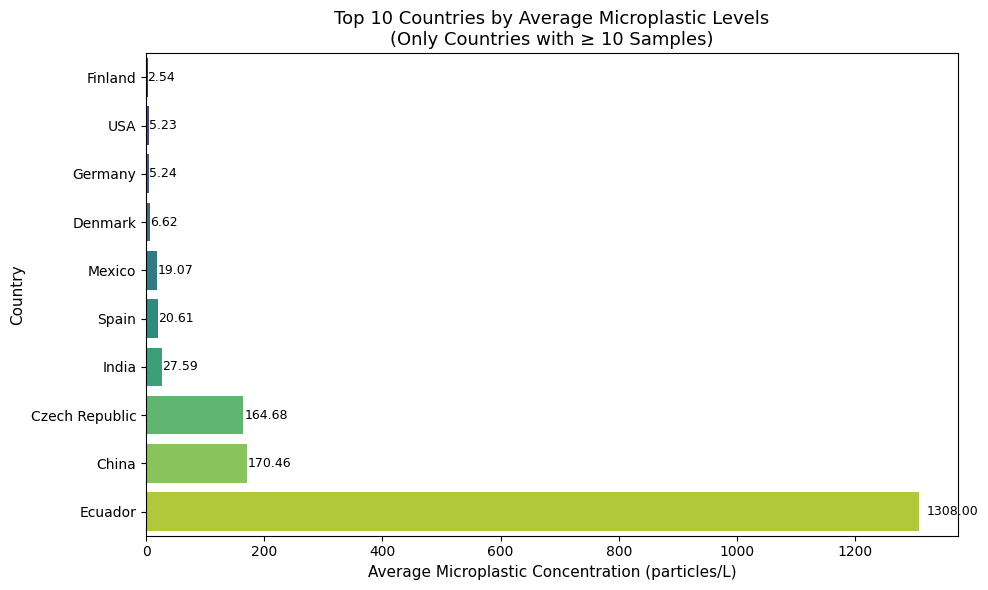

In [89]:
# Plot: Top 10 Countries by Average Standardized Concentration
plt.figure(figsize=(10, 6))
ax2 = sns.barplot(data=top10_avg, x='avg_std_concentration', y='Countries', palette='viridis')
plt.xlabel('Average Microplastic Concentration (particles/L)', fontsize=11)
plt.ylabel('Country', fontsize=11)
plt.title('Top 10 Countries by Average Microplastic Levels\n(Only Countries with ≥ 10 Samples)', fontsize=13)

# Annotate bars with the average concentration values
for patch in ax2.patches:
    width = patch.get_width()
    ax2.text(width + (width * 0.01),
             patch.get_y() + patch.get_height() / 2,
             f'{width:.2f}',
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()

#### Count Plot: Filtration Methods (USA vs Germany)
This plot shows the number of samples for each identification (filtration) method for the USA and Germany.

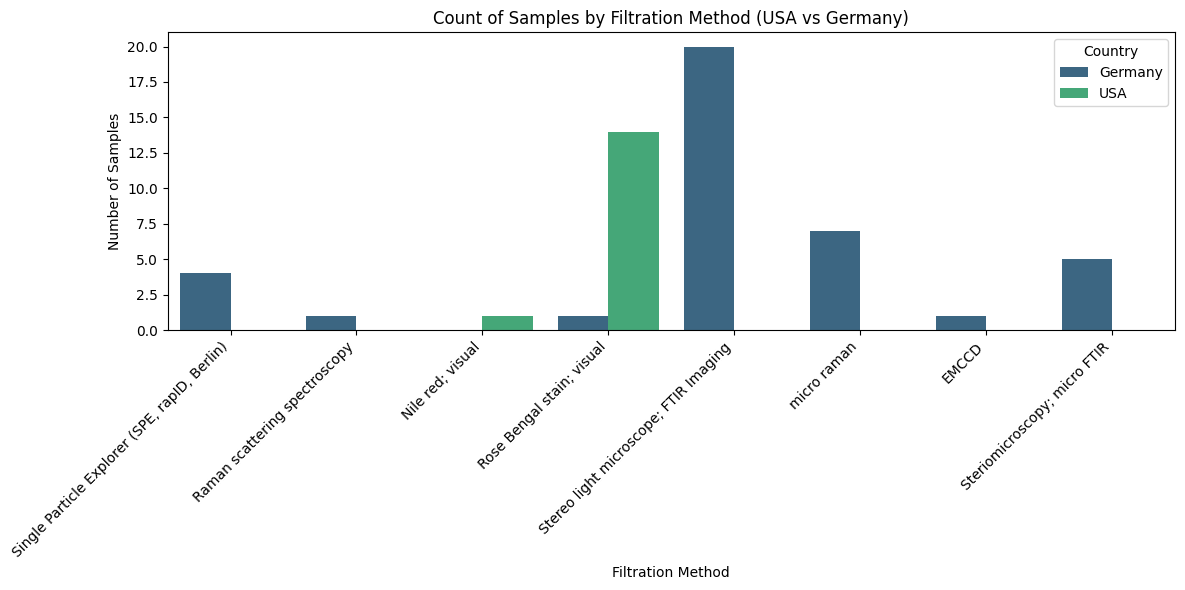

In [90]:
# Filter data for USA and Germany
df = df[df['Countries'].isin(['USA', 'Germany'])]

# Remove rows with "Not Provided" in the identification method
df = df[df['Microplastic_Identification_Method'] != "Not Provided"]

# Plot: Count of Samples by Filtration (Identification) Method for USA vs Germany
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Microplastic_Identification_Method', hue='Countries', palette='viridis')
plt.title('Count of Samples by Filtration Method (USA vs Germany)')
plt.xlabel('Filtration Method')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Country')
plt.tight_layout()
plt.show()

#### Effectiveness Analysis
This section classifies samples as "Effective" or "Ineffective" based on a defined concentration threshold and displays the proportions using a stacked bar chart.

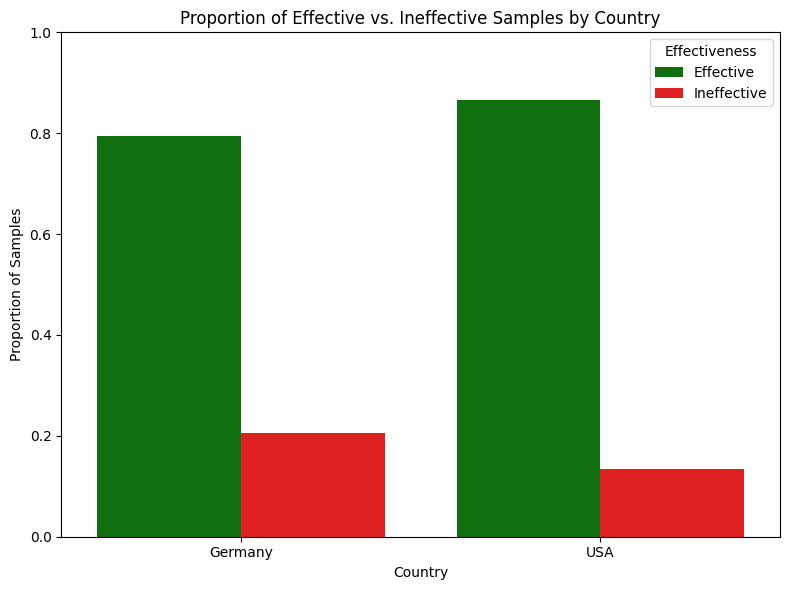

In [91]:
# Define threshold for effectiveness
threshold = 10
df['Effectiveness'] = df['Concentration'].apply(lambda x: 'Effective' if x < threshold else 'Ineffective')

# Group by Country and Effectiveness and calculate sample counts
eff_summary = df.groupby(['Countries', 'Effectiveness']).size().unstack(fill_value=0)

# Convert raw counts to proportions for each country
eff_prop = eff_summary.div(eff_summary.sum(axis=1), axis=0).reset_index()

# Reshape data for plotting
eff_melted = eff_prop.melt(id_vars='Countries', var_name='Effectiveness', value_name='Proportion')

plt.figure(figsize=(8, 6))
sns.barplot(data=eff_melted, x='Countries', y='Proportion', hue='Effectiveness', palette=['green', 'red'])
plt.title('Proportion of Effective vs. Ineffective Samples by Country')
plt.xlabel('Country')
plt.ylabel('Proportion of Samples')
plt.ylim(0, 1)
plt.legend(title='Effectiveness')
plt.tight_layout()
plt.show()

### Microplastic Concentration by Filtration Method

This cell:
- Loads and cleans the dataset by removing rows missing location information.
- Converts the **Concentration** column to numeric and drops rows where conversion fails.
- Renames the `Microplastic_Identification_Method` column to `Identification_Method` for clarity.
- Groups the data by identification method, calculating the total concentration and sample count.
- Filters to keep only methods with at least 5 samples, then selects the top 10 by total concentration.
- Plots a bar chart of the top 10 methods.

C:\Users\arman\AppData\Local\Temp\ipykernel_1996\3262303350.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


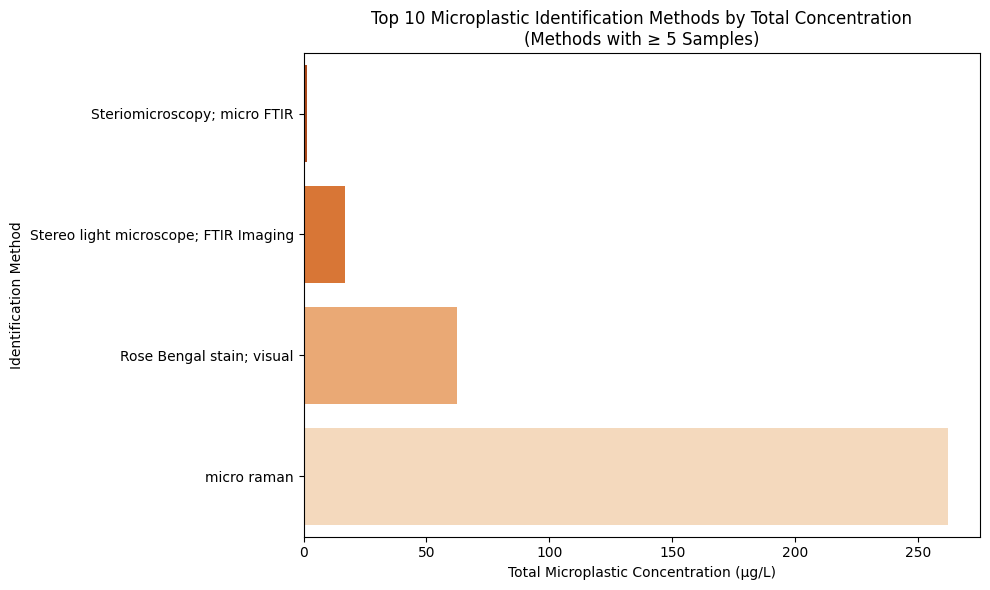

In [92]:
# Assumes df is already loaded and cleaned earlier in the narrative
# Drop rows missing location details if needed (already done during cleaning)
df = df[~df['Location'].isnull()]
df = df.dropna(subset=['Approximate_Latitude', 'Approximate_Longitude'])

# Convert Concentration to numeric if not already done
df['Concentration'] = pd.to_numeric(df['Concentration'], errors='coerce')
df = df.dropna(subset=['Concentration'])

# Rename the identification method column for clarity
df = df.rename(columns={'Microplastic_Identification_Method': 'Identification_Method'})

# Group by identification method and calculate sum of concentration and sample count
method_stats = df.groupby('Identification_Method').agg(
    total_concentration=('Concentration', 'sum'),
    sample_count=('Concentration', 'count')
).reset_index()

# Retain only methods with at least 5 samples and select top 10 by total concentration
method_stats = method_stats[method_stats['sample_count'] >= 5]
top10_methods = method_stats.sort_values(by='total_concentration', ascending=False).head(10)

# Plot a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10_methods.sort_values(by='total_concentration'),
    x='total_concentration',
    y='Identification_Method',
    palette='Oranges_r'
)
plt.xlabel("Total Microplastic Concentration (µg/L)")
plt.ylabel("Identification Method")
plt.title("Top 10 Microplastic Identification Methods by Total Concentration\n(Methods with ≥ 5 Samples)")
plt.tight_layout()
plt.show()

### Average Microplastic Concentration by Filtration Method (USA vs Germany)

This cell:
- Loads and cleans the dataset (ensuring location, latitude, and concentration information are complete).
- Renames the identification column.
- Finds the top 10 most common identification methods.
- Filters the dataset to keep only these common methods.
- Computes the average microplastic concentration for each method and plots them.

C:\Users\arman\AppData\Local\Temp\ipykernel_1996\4058394805.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_conc.values, y=mean_conc.index, palette='Blues_r')


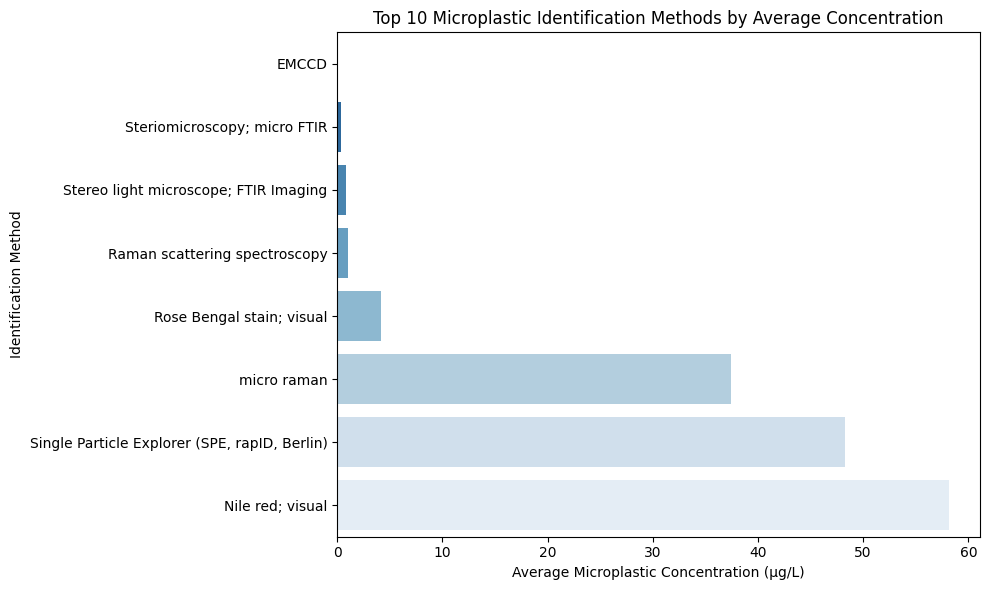

In [93]:
# Assumes df is already loaded and cleaned
# Rename the column if not done already
df = df.rename(columns={'Microplastic_Identification_Method': 'Identification_Method'})

# Identify the top 10 most common identification methods
top_methods = df['Identification_Method'].value_counts().head(10).index
filtered_df = df[df['Identification_Method'].isin(top_methods)]

# Compute the average concentration for each method
mean_conc = filtered_df.groupby('Identification_Method')['Concentration'].mean().sort_values()

# Plot average concentration for each identification method
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_conc.values, y=mean_conc.index, palette='Blues_r')
plt.xlabel("Average Microplastic Concentration (µg/L)")
plt.ylabel("Identification Method")
plt.title("Top 10 Microplastic Identification Methods by Average Concentration")
plt.tight_layout()
plt.show()

###  Average Microplastic Concentration by Filtration Method (USA vs Germany)
This cell identifies the top 10 most common identification methods, filters the dataset to include these methods, calculates the average concentration for each, and plots the results in a horizontal bar chart.

C:\Users\arman\AppData\Local\Temp\ipykernel_1996\1579749559.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_conc.values, y=mean_conc.index, palette='Blues_r')


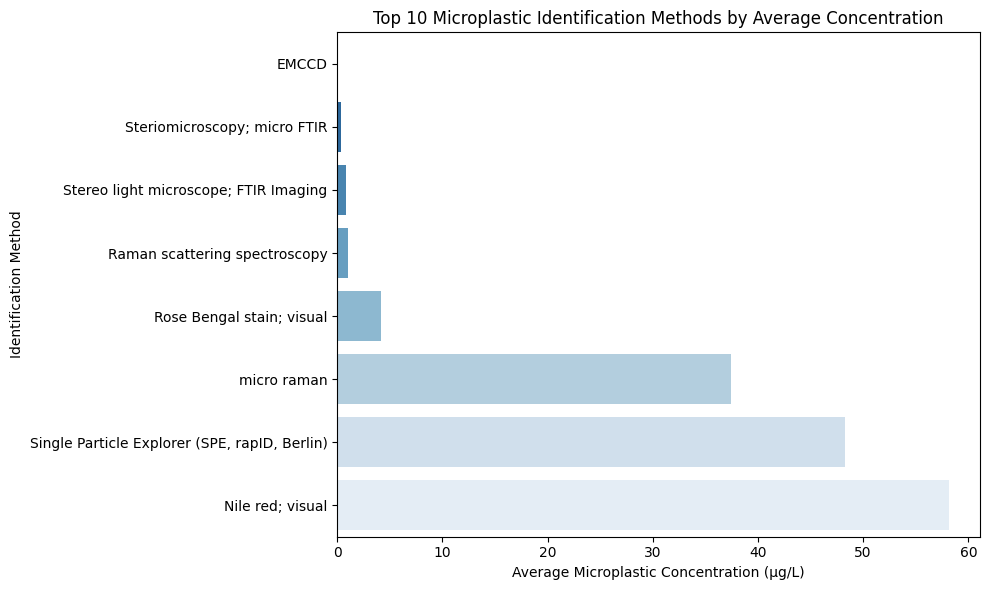

In [94]:
# Rename the column for clarity if not done already
df = df.rename(columns={'Microplastic_Identification_Method': 'Identification_Method'})

# Identify the top 10 most common identification methods
top_methods = df['Identification_Method'].value_counts().head(10).index
filtered_df = df[df['Identification_Method'].isin(top_methods)]

# Compute the average concentration for each method
mean_conc = filtered_df.groupby('Identification_Method')['Concentration'].mean().sort_values()

# Plot the average concentration
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_conc.values, y=mean_conc.index, palette='Blues_r')
plt.xlabel("Average Microplastic Concentration (µg/L)")
plt.ylabel("Identification Method")
plt.title("Top 10 Microplastic Identification Methods by Average Concentration")
plt.tight_layout()
plt.show()

### Box Plot of Microplastic Concentration by Identification Method (USA vs Germany)
This cell creates a box plot to compare the distribution of microplastic concentrations across different identification methods between USA and Germany.

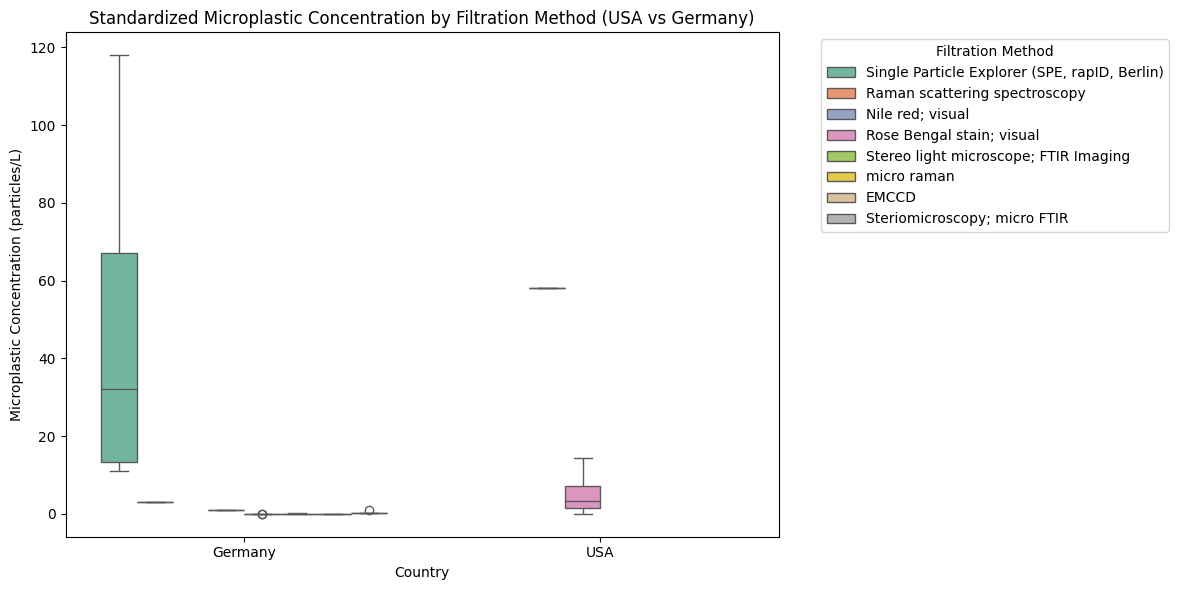

['Germany' 'USA']


In [95]:
# Filter the dataset for USA and Germany
usa_ger = df[df['Countries'].isin(['USA', 'Germany'])]

# Remove rows with "Not Provided" in the identification method
usa_ger = usa_ger[usa_ger['Identification_Method'] != "Not Provided"]

plt.figure(figsize=(12, 6))
sns.boxplot(x='Countries', y='Concentration_std', hue='Identification_Method', data=usa_ger, palette='Set2')
plt.title('Standardized Microplastic Concentration by Filtration Method (USA vs Germany)')
plt.xlabel('Country')
plt.ylabel('Microplastic Concentration (particles/L)')
plt.legend(title='Filtration Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Confirm both USA and Germany are present
print(usa_ger['Countries'].unique())

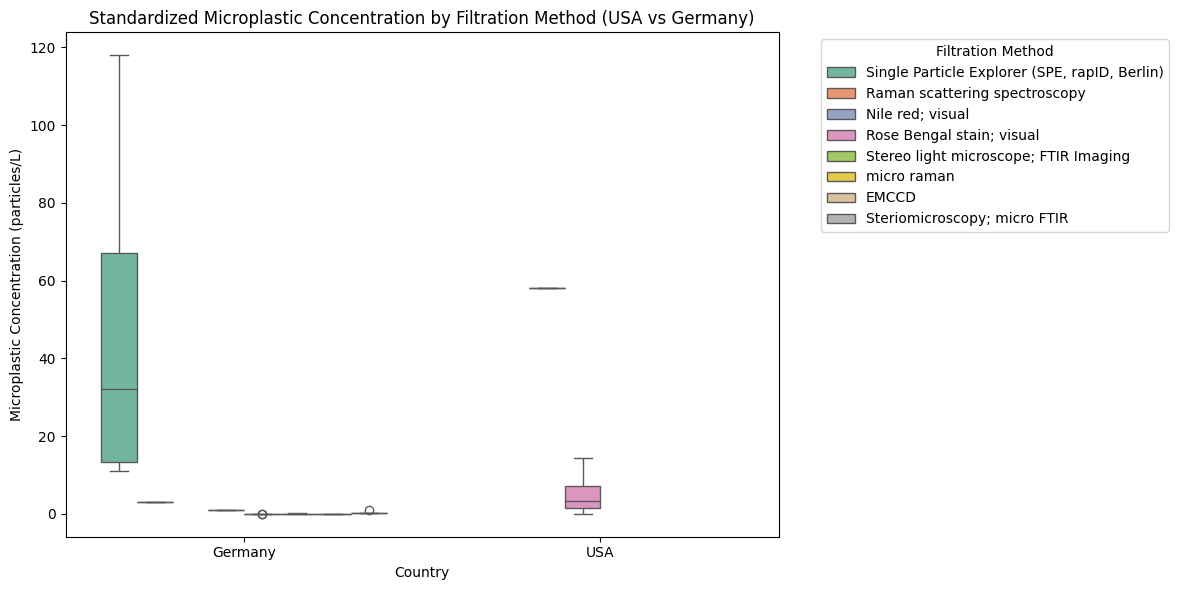

['Germany' 'USA']


In [96]:
# Filter the dataset for USA and Germany using .isin()
usa_ger = df[df['Countries'].isin(['USA', 'Germany'])]

# Remove rows with "Not Provided" in the identification method
usa_ger = usa_ger[usa_ger['Identification_Method'] != "Not Provided"]

# Create the box plot comparing standardized concentrations by identification method and country
plt.figure(figsize=(12, 6))
sns.boxplot(x='Countries', y='Concentration_std', hue='Identification_Method', data=usa_ger, palette='Set2')
plt.title('Standardized Microplastic Concentration by Filtration Method (USA vs Germany)')
plt.xlabel('Country')
plt.ylabel('Microplastic Concentration (particles/L)')
plt.legend(title='Filtration Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Confirm both USA and Germany are present
print(usa_ger['Countries'].unique())

In [97]:
usa_ger['Countries'].unique()

array(['Germany', 'USA'], dtype=object)

In [98]:
df.isnull().sum()

Unnamed: 0                              0
DOI                                     0
Sample_ID                               0
Location                                0
Countries                               0
Source                                  0
Concentration                           0
Concentration_Units                     0
Approximate_Latitude                    0
Approximate_Longitude                   0
Sample_device_and_deployment_methods    0
Digestion                               0
Filtration                              0
Filter_Size                             0
Identification_Method                   0
Spectral_Analysis                       0
Controls                                0
Concentration_std                       0
Effectiveness                           0
dtype: int64

###  Stacked Bar Chart of Filtration Methods by Country
This cell removes samples with a "Not Provided" identification, groups the data by country and identification method, and plots a stacked bar chart to show sample counts.

<Figure size 1200x600 with 0 Axes>

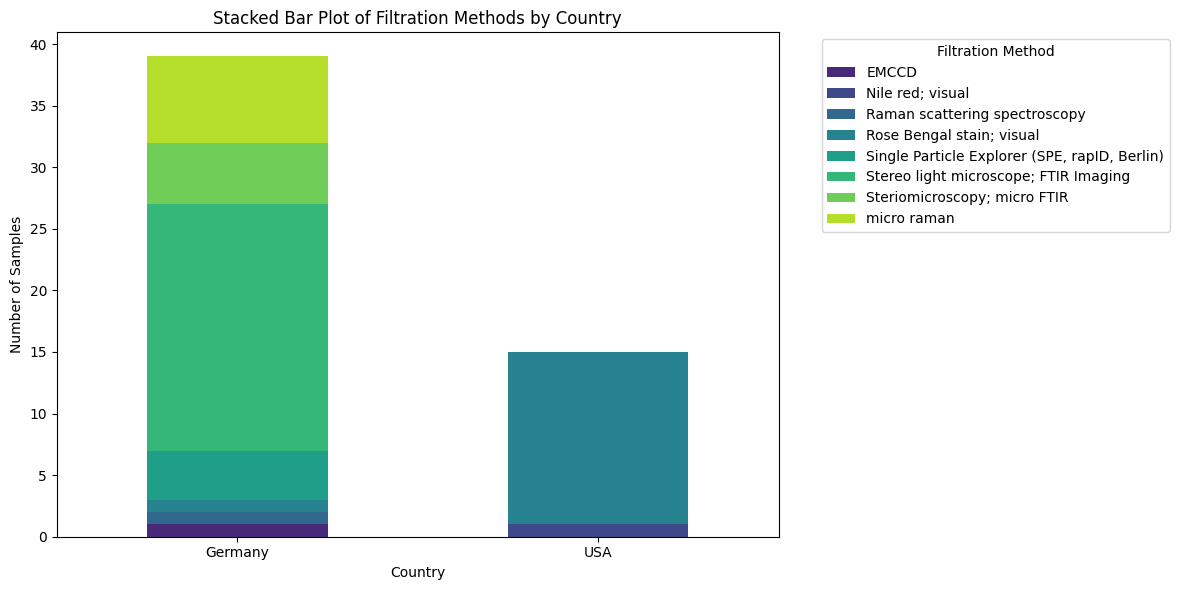

In [99]:
# Remove samples with "Not Provided" in the identification method
usa_ger = usa_ger[usa_ger['Identification_Method'] != "Not Provided"]

# Group by Countries and Identification Method to get sample counts
country_method_counts = usa_ger.groupby(['Countries', 'Identification_Method']).size().unstack()

# Plot the stacked bar chart
plt.figure(figsize=(12, 6))
country_method_counts.plot(kind='bar', stacked=True, figsize=(12, 6),
                           color=sns.color_palette('viridis', n_colors=len(country_method_counts.columns)))
plt.title('Stacked Bar Plot of Filtration Methods by Country')
plt.xlabel('Country')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.legend(title='Filtration Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### ANOVA Test: Does Filtration Method Affect Concentration?  
This cell runs a one-way ANOVA to test whether the mean standardized concentration differs across filtration methods.

In [100]:
from scipy.stats import f_oneway

groups = [group["Concentration_std"].values for name, group in df.groupby("Filtration")]
f_stat, p_val = f_oneway(*groups)

print(f"F-statistic: {f_stat:.4f}, p-value: {p_val:.4f}")

F-statistic: 9.5218, p-value: 0.0000


## ANOVA Test

In [101]:
import scipy.stats as stats

# Assuming you've already filtered for USA and Germany

# Group the data by 'Filtration' for each country
usa_groups = [group["Concentration_std"].values for name, group in df[df["Countries"] == "USA"].groupby("Filtration")]
germany_groups = [group["Concentration_std"].values for name, group in df[df["Countries"] == "Germany"].groupby("Filtration")]

# Perform the ANOVA test for both USA and Germany
usa_f_stat, usa_p_val = stats.f_oneway(*usa_groups)
germany_f_stat, germany_p_val = stats.f_oneway(*germany_groups)

# Degrees of freedom (between-group and within-group for each country)
# k is the number of groups in each country
usa_k = len(usa_groups)
germany_k = len(germany_groups)
usa_n = len(df[df["Countries"] == "USA"])
germany_n = len(df[df["Countries"] == "Germany"])

usa_between_df = usa_k - 1
usa_within_df = usa_n - usa_k
germany_between_df = germany_k - 1
germany_within_df = germany_n - germany_k

# Printing the results in the requested format
print(f"USA: F({usa_between_df}, {usa_within_df}) = {usa_f_stat:.2f}, p = {usa_p_val:.4f}")
print(f"Germany: F({germany_between_df}, {germany_within_df}) = {germany_f_stat:.2f}, p = {germany_p_val:.4f}")


USA: F(1, 13) = 164.71, p = 0.0000
Germany: F(6, 32) = 5.96, p = 0.0003


In [102]:
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Filter data for USA and Germany
usa_data = df[df["Countries"] == "USA"]
germany_data = df[df["Countries"] == "Germany"]

# Group by filtration method and calculate the mean for each method
usa_grouped = usa_data.groupby('Filtration')['Concentration_std'].mean()
germany_grouped = germany_data.groupby('Filtration')['Concentration_std'].mean()

# Print the means for both countries
print("USA Filtration Method Means:")
print(usa_grouped)
print("\nGermany Filtration Method Means:")
print(germany_grouped)

# Perform Tukey's HSD test for USA and Germany

# Tukey's test for USA
usa_tukey = pairwise_tukeyhsd(usa_data['Concentration_std'], usa_data['Filtration'])
print("\nUSA Tukey HSD Test Results:")
print(usa_tukey.summary())

# Tukey's test for Germany
germany_tukey = pairwise_tukeyhsd(germany_data['Concentration_std'], germany_data['Filtration'])
print("\nGermany Tukey HSD Test Results:")
print(germany_tukey.summary())


USA Filtration Method Means:
Filtration
Glass fiber                58.200000
Whatman cellulose fiber     4.387857
Name: Concentration_std, dtype: float64

Germany Filtration Method Means:
Filtration
Cellulose nitrate             3.030303
PC filter                     0.000000
Stainless steel               0.003952
Whatman cellulose fiber       0.910000
polycarbonate filter         48.250000
stainless steel               0.032667
stainless steel; membrane     0.320000
Name: Concentration_std, dtype: float64

USA Tukey HSD Test Results:
            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
   group1            group2         meandiff p-adj  lower    upper   reject
---------------------------------------------------------------------------
Glass fiber Whatman cellulose fiber -53.8121   0.0 -62.8706 -44.7537   True
---------------------------------------------------------------------------

Germany Tukey HSD Test Results:
                   Multiple Comparison of Mean

### Violin Plot: Distribution of Standardized Concentrations (USA vs. Germany)

*Methodology:*  
We filter for the two countries, then draw violin plots of `Concentration_std` to compare their distribution shapes, medians, and variability.

C:\Users\arman\AppData\Local\Temp\ipykernel_1996\3385499143.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


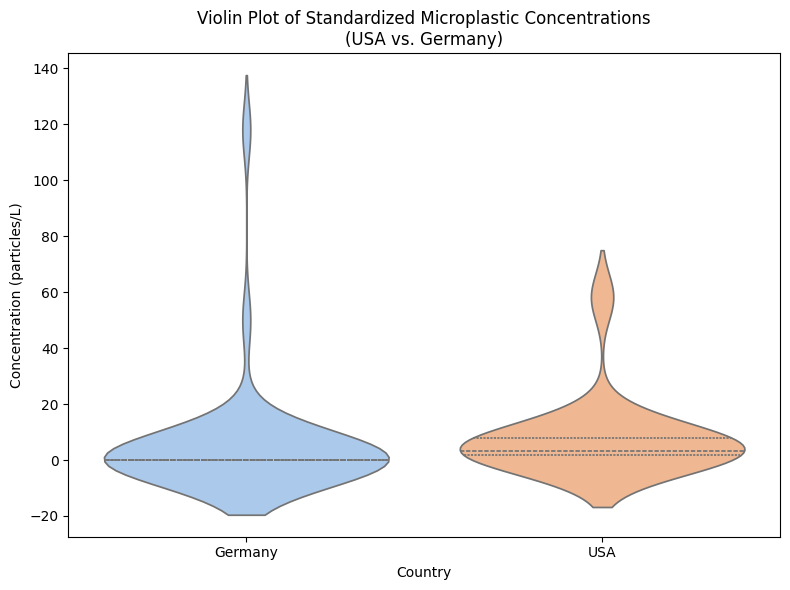

In [ ]:
# Subset for USA & Germany without modifying df
df_sub = df[df['Countries'].isin(['USA', 'Germany'])]

plt.figure(figsize=(8,6))
sns.violinplot(
    data=df_sub,
    x='Countries',
    y='Concentration_std',
    inner='quartile',
    palette='pastel'
)
plt.title('Violin Plot of Standardized Microplastic Concentrations\n(USA vs. Germany)')
plt.xlabel('Country')
plt.ylabel('Concentration (particles/L)')
plt.tight_layout()
plt.show()

### Scatter Plot: Concentration vs. Latitude by Country

*Methodology:*  
Assuming `Approximate_Latitude` is present, we plot each sample’s standardized concentration against its latitude, coloring points by country to look for geographic trends.

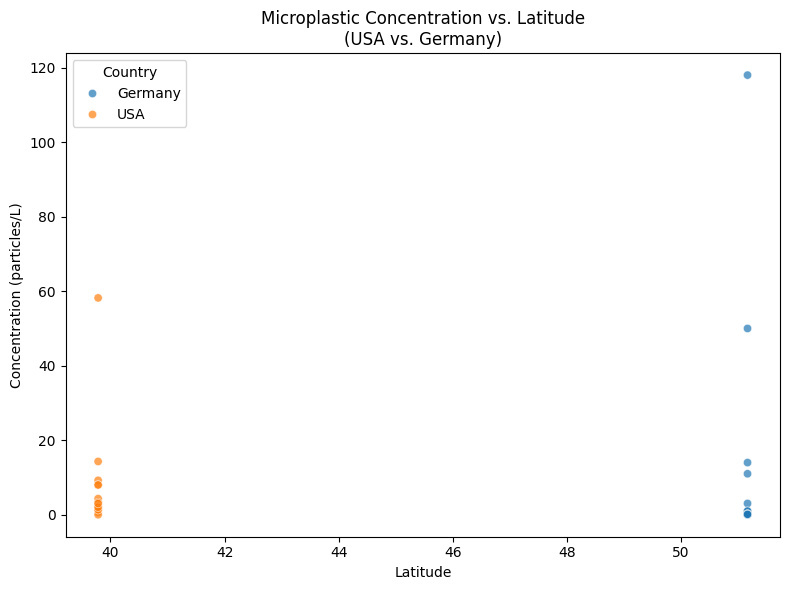

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_sub,
    x='Approximate_Latitude',
    y='Concentration_std',
    hue='Countries',
    alpha=0.7,
    edgecolor='w'
)
plt.title('Microplastic Concentration vs. Latitude\n(USA vs. Germany)')
plt.xlabel('Latitude')
plt.ylabel('Concentration (particles/L)')
plt.legend(title='Country')
plt.tight_layout()
plt.show()

### Linear Regression: Effect of Country on Concentration

*Methodology:*  
We build an OLS model (`Concentration_std ~ C(Countries)`) to estimate how much being in the USA versus Germany shifts the average microplastic concentration.

In [ ]:
import statsmodels.formula.api as smf

# Fit model on the subset
model = smf.ols('Concentration_std ~ C(Countries)', data=df_sub).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Concentration_std   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.2500
Date:                Sun, 27 Apr 2025   Prob (F-statistic):              0.619
Time:                        20:11:26   Log-Likelihood:                -234.43
No. Observations:                  54   AIC:                             472.9
Df Residuals:                      52   BIC:                             476.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.0979    

### Logistic Regression: Predicting Country from Concentration (and Method)

*Methodology:*  
We encode `Identification_Method` on the fly via a `Pipeline` and train a logistic regression to classify whether a sample is from USA or Germany based on its standardized concentration and method.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Prepare data
X = df_sub[['Concentration_std', 'Identification_Method']]
y = df_sub['Countries']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Pipeline: scale concentration, one-hot encode method
preproc = ColumnTransformer([
    ('num', StandardScaler(), ['Concentration_std']),
    ('cat', OneHotEncoder(drop='first'), ['Identification_Method'])
])

pipe = Pipeline([
    ('pre', preproc),
    ('clf', LogisticRegression(solver='liblinear'))
])

# Train & evaluate
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
              precision    recall  f1-score   support

     Germany       1.00      1.00      1.00        12
         USA       1.00      1.00      1.00         5

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



### K-Means Clustering: Grouping Samples by Concentration

*Methodology:*  
We cluster the samples into two groups based solely on `Concentration_std` and then check how those clusters map onto USA vs. Germany.

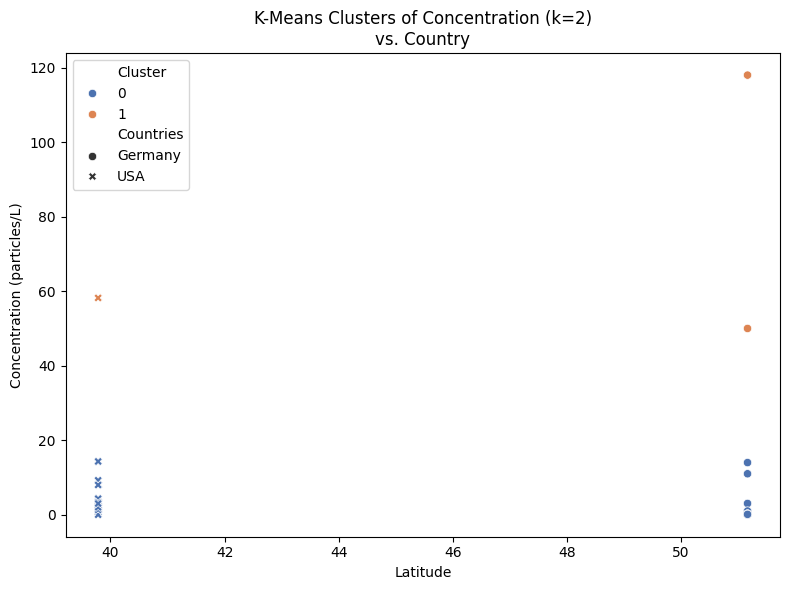

In [ ]:
from sklearn.cluster import KMeans

# Only use concentration_std for clustering
X_km = df_sub[['Concentration_std']].values

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_km)

# Add cluster labels temporarily
df_sub_temp = df_sub.assign(Cluster=clusters.astype(str))

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_sub_temp,
    x='Approximate_Latitude',
    y='Concentration_std',
    hue='Cluster',
    style='Countries',
    palette='deep'
)
plt.title('K-Means Clusters of Concentration (k=2)\nvs. Country')
plt.xlabel('Latitude')
plt.ylabel('Concentration (particles/L)')
plt.tight_layout()
plt.show()

In [ ]:
df.shape

(54, 19)

In [ ]:
# Assuming 'df' is your DataFrame
country_counts = df['Countries'].value_counts()

print(country_counts)


Countries
Germany    39
USA        15
Name: count, dtype: int64


In [ ]:
# Assuming 'df' is your DataFrame
# Group by the 'Countries' column and calculate the mean and standard deviation of 'Concentration'
country_stats = df.groupby('Countries')['Concentration'].agg(['mean', 'std'])

print(country_stats)


                mean        std
Countries                      
Germany    12.192564  29.127326
USA         7.975333  14.432149


  Countries                 Filtration  Concentration_std
0   Germany          Cellulose nitrate           3.030303
1   Germany                  PC filter           0.000000
2   Germany            Stainless steel           0.010333
3   Germany    Whatman cellulose fiber           0.910000
4   Germany       polycarbonate filter          48.250000
5   Germany  stainless steel; membrane           0.320000
6       USA                Glass fiber          58.200000
7       USA    Whatman cellulose fiber           4.387857


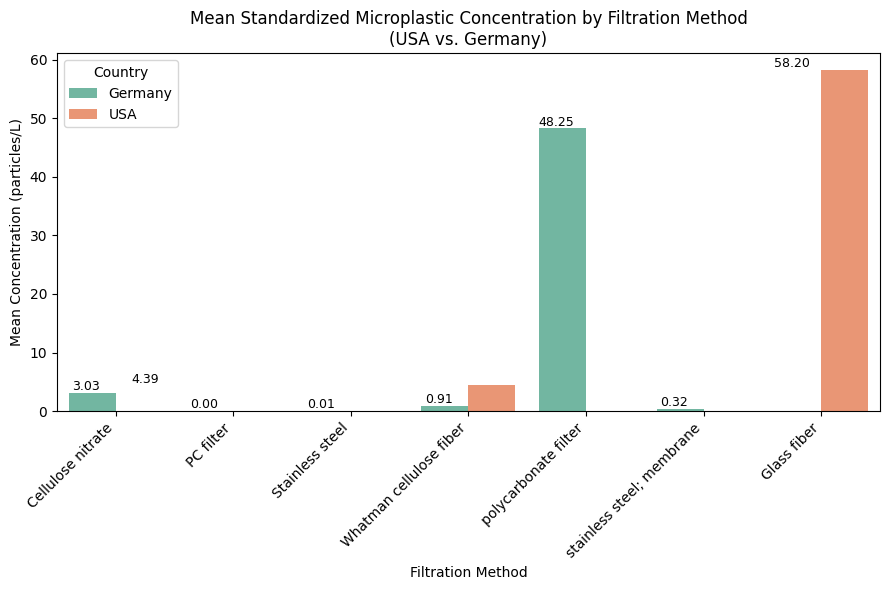

In [ ]:
# Ensure the filtration column is clean by standardizing the values
df_sub['Filtration'] = df_sub['Filtration'].replace({
    'stainless steel': 'Stainless steel',  # Fix capitalization
})

# Re-group and recalculate the means for each Filtration method by country
grouped = df_sub.groupby(['Countries', 'Filtration'])['Concentration_std'].mean().reset_index()

# Check the grouped data to ensure correct values are present
print(grouped)

# Now plot the grouped data
plt.figure(figsize=(9, 6))
sns.barplot(
    data=grouped,
    x='Filtration',
    y='Concentration_std',
    hue='Countries',
    palette='Set2'
)

# Add exact values on top of bars
for i in range(len(grouped)):
    plt.text(
        x=i % grouped['Filtration'].nunique() - 0.25 + 0.5*(i//grouped['Filtration'].nunique()), 
        y=grouped['Concentration_std'][i] + 0.5, 
        s=f"{grouped['Concentration_std'][i]:.2f}", 
        ha='center',
        fontsize=9
    )

plt.title('Mean Standardized Microplastic Concentration by Filtration Method\n(USA vs. Germany)')
plt.xlabel('Filtration Method')
plt.ylabel('Mean Concentration (particles/L)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Country')
plt.tight_layout()
plt.show()


# All done